# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

Заказчик этого исследования — сеть отелей «Как в гостях».  


Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.

Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

### Шаг 1. Откройте файлы с данными

Загрузим необходимые библиотеки для работы

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder

Сохраним датафреймы `hotel_train.csv` и `hotel_test.csv` в переменные

In [ ]:
hotel_train = pd.read_csv('/datasets/hotel_train.csv')
hotel_test = pd.read_csv('/datasets/hotel_test.csv')

Посмотрим на начальные записи в датафреймах

In [ ]:
hotel_train.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


In [ ]:
hotel_test.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


Из предоставленных для исследования данных, нам известно, что,

В таблицах `hotel_train` и `hotel_test` содержатся одинаковые столбцы:  
**id** — номер записи;  
**adults** — количество взрослых постояльцев;  
**arrival_date_year** — год заезда;  
**arrival_date_month** — месяц заезда;  
**arrival_date_week_number** — неделя заезда;  
**arrival_date_day_of_month** — день заезда;  
**babies** — количество младенцев;  
**booking_changes** — количество изменений параметров заказа;  
**children** — количество детей от 3 до 14 лет;  
**country** — гражданство постояльца;  
**customer_type** — тип заказчика:  
   - Contract — договор с юридическим лицом;  
   - Group — групповой заезд;  
   - Transient — не связано с договором или групповым заездом;  
   - Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.  

**days_in_waiting_list** — сколько дней заказ ожидал подтверждения;  
**distribution_channel** — канал дистрибуции заказа;  
**is_canceled** — отмена заказа;  
**is_repeated_guest** — признак того, что гость бронирует номер второй раз;  
**lead_time** — количество дней между датой бронирования и датой прибытия;  
**meal** — опции заказа:  
   - SC — нет дополнительных опций;  
   - BB — включён завтрак;  
   - HB — включён завтрак и обед;  
   - FB — включён завтрак, обед и ужин.  
   
**previous_bookings_not_canceled** — количество подтверждённых заказов у клиента;  
**previous_cancellations** — количество отменённых заказов у клиента;  
**required_car_parking_spaces** — необходимость места для автомобиля;  
**reserved_room_type** — тип забронированной комнаты;  
**stays_in_weekend_nights** — количество ночей в выходные дни;  
**stays_in_week_nights** — количество ночей в будние дни;  
**total_nights** — общее количество ночей;  
**total_of_special_requests** — количество специальных отметок.  

### Шаг 2. Предобработка и исследовательский анализ данных

#### Общая информация о датафреймах

In [ ]:
hotel_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [ ]:
hotel_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

В датафрейме `hotel_train` 65229 записей, В датафрейме `hotel_test` 32412 записей. Пропущенных значений нет.

#### Поиск дубликатов

In [ ]:
print(hotel_test.duplicated().sum())
print(hotel_train.duplicated().sum())

0
0


Явных дубликатов не обнаружено.

Поищем дубликаты в категориальных столбцах датафрейма

In [ ]:
hotel_train['meal'].unique()

array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
      dtype=object)

In [ ]:
hotel_test['meal'].unique()

array(['BB       ', 'HB       ', 'SC', 'FB       ', 'SC       '],
      dtype=object)

Обнаружены лишние пробелы в написании. Не явные дубликаты: `'SC       ',` `'SC'`. Исправим это.

In [ ]:
hotel_test['meal'] = hotel_test['meal'].str.strip()
hotel_train['meal'] = hotel_train['meal'].str.strip()

Проверив, выведем на экран категории содержащиеся в этих столбцах

In [ ]:
hotel_test['meal'].value_counts()

BB    24684
SC     5293
HB     2399
FB       36
Name: meal, dtype: int64

In [ ]:
hotel_train['meal'].value_counts()

BB    51697
HB     7292
SC     5789
FB      451
Name: meal, dtype: int64

Посмотрим на уникальные значения для столбца **reserved_room_type** в двух датафреймах

In [ ]:
hotel_train['reserved_room_type'].unique()

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

In [ ]:
hotel_test['reserved_room_type'].unique()

array(['A               ', 'E               ', 'G               ',
       'D               ', 'F               ', 'C               ',
       'B               '], dtype=object)

Обнаружены пробелы в написании, исправим это, и результат выведем на экран

In [ ]:
hotel_test['reserved_room_type'] = hotel_test['reserved_room_type'].str.strip()
hotel_train['reserved_room_type'] = hotel_train['reserved_room_type'].str.strip()
print(hotel_train['reserved_room_type'].unique())
print(hotel_train['reserved_room_type'].unique())

['A' 'C' 'D' 'E' 'G' 'F' 'B']
['A' 'C' 'D' 'E' 'G' 'F' 'B']


#### Изменение типов данных

Столбцы **lead_time**, **adults**, **children**, **babies** имеют тип данных `float64`, изменим тип данных на целочисленный `int64`.

In [ ]:
columns = ['lead_time', 'adults', 'children', 'babies']
tables = [hotel_test, hotel_train]
for table in tables:
    for col in columns:
        table[col] = table[col].astype('int64')

#### Избавляемся от выбросов

Исследуем датафреймы, взглянем на количественные переменные методом `describe`

In [ ]:
hotel_train.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


In [ ]:
hotel_test.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,60131.505183,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


Вывод:
 - Явный перекос в данных в столбце **lead_time**, необходимо рассмотреть подробнее
 - Минимальное значение в столбце **adults** равно 0, чего быть не должно
 - В столбце **babies** датафрейма `hotel_train ` максимальное значение 10, необходимо будет подробнее рассмотреть
 - В столбце **required_car_parking_spaces** изучить аномально большие значения (8)
 - В столбце **booking_changes** подозрительные значения 17 и 18, при медиане 0, необходимо будет изучить детальнее
 - В столбце **days_in_waiting_list** (сколько дней заказ ожидал подтверждения), медиана 0, 3 квартиль тоже 0, а максимальные значения 259 и 223, необходимо детально изучить это

Посмотрим детальнее на столбец **lead_time** (количество дней между датой бронирования и датой прибытия). Построим диаграмму размаха

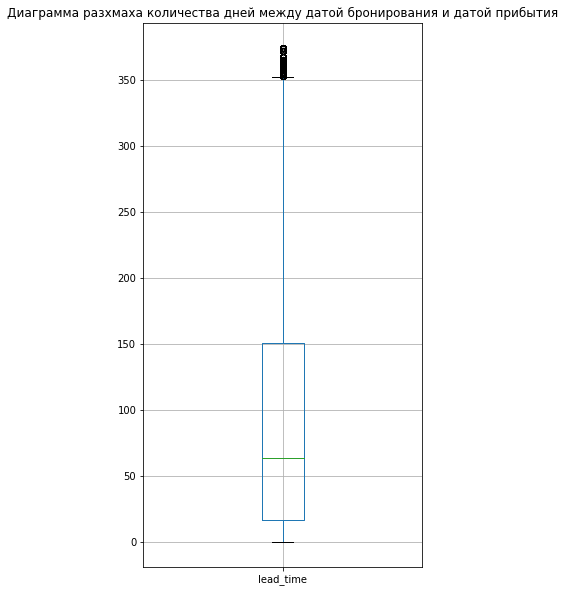

In [ ]:
hotel_train['lead_time'].plot(kind='box',figsize=(5,10), grid=True, legend=True, title='Диаграмма разхмаха количества дней между датой бронирования и датой прибытия')
plt.show()

Из диаграммы выше, можно сделать вывод, что все значения выше 350-ти будем считать выбросами. Возможные причины что пользователи бронируют много заранее, за год, отсюда значения больше 350. Посмотрим сколько таких значений

In [ ]:
hotel_train.query('lead_time>350')['lead_time'].count()

567

567 значений, это порядка 1 % от всех данных, этим можно принебречь, удалим данные

In [ ]:
hotel_train = hotel_train.query('lead_time<350')

Посмотрим диграмму размаха для тестовой выборки

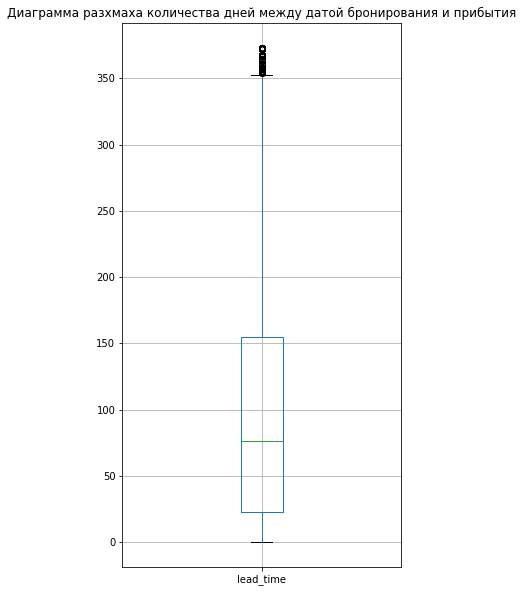

In [ ]:
hotel_test['lead_time'].plot(kind='box',figsize=(5,10), grid=True, legend=True, title='Диаграмма разхмаха количества дней между датой бронирования и прибытия')
plt.show()

Аналогичная ситуация, значения больше 350 - удаляем

In [ ]:
hotel_test = hotel_test.query('lead_time<350')

В столбце **adults** ранее были обнаружены знаечния с `0`, взрослых постояльцев, по идее, при регистрации быть не должно. Возможная причина появления 0, это ошибка загрузки данных с сервера, или при регистрации пользователь не заполнил эти поля, необходимо будет уточнять у человека производившего выгрузку данных. Записи с нулемым значением удаляем из датафреймов.

In [ ]:
hotel_train = hotel_train.query('adults!=0')
hotel_test = hotel_test.query('adults!=0')

Рассмотрим значения которые лежат в столбце **babies** датафрейма `hotel_train`

In [ ]:
hotel_train['babies'].value_counts()

0     63975
1       443
2         3
9         1
10        1
Name: babies, dtype: int64

Значения 9 и 10 (количество младенцев) явно считается ошибкой, это выбросы. Таких значений мало, удаляем их

In [ ]:
hotel_train = hotel_train.query('babies < 9')

Вглянем на столбец **required_car_parking_spaces** (необходимость места для автомобиля) в датафреймах. Посчитаем количество записей для каждого значения в датафреймах

In [ ]:
display(hotel_test['required_car_parking_spaces'].value_counts())
display(hotel_train['required_car_parking_spaces'].value_counts())

0    30664
1     1465
2        6
8        2
3        1
Name: required_car_parking_spaces, dtype: int64

0    60754
1     3655
2       11
3        1
Name: required_car_parking_spaces, dtype: int64

Из описания столбца (необходимость места для автомобиля) сделаем вывод, что или место не нужно и это значение 0, или нужно - значение столбца 1, все остальные записи (2, 3, 8) будем считать выбросами. Удалим эти записи.

In [ ]:
hotel_train = hotel_train.query('required_car_parking_spaces < 2')
hotel_test = hotel_test.query('required_car_parking_spaces < 2')

Вглянем на столбец **booking_changes** (количество изменений параметров заказа). Из первичного анализы мы видели, что максимальные значения достигают 17 и 18 в датафреймах `hotel_train` и `hotel_test`, при медиане в 0, третий квартиль 0. Построим гистограмму для частоты количества изменений параметров заказа для двух датафреймов

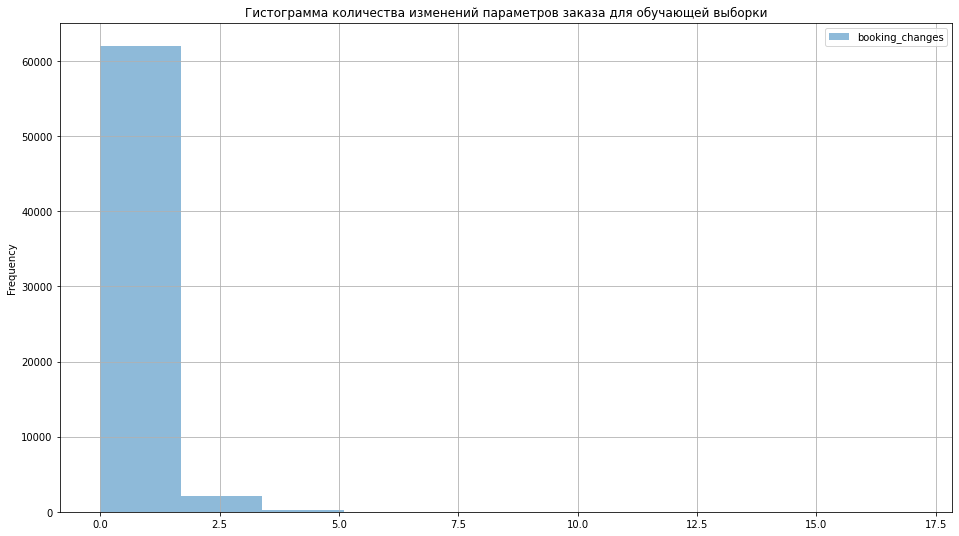

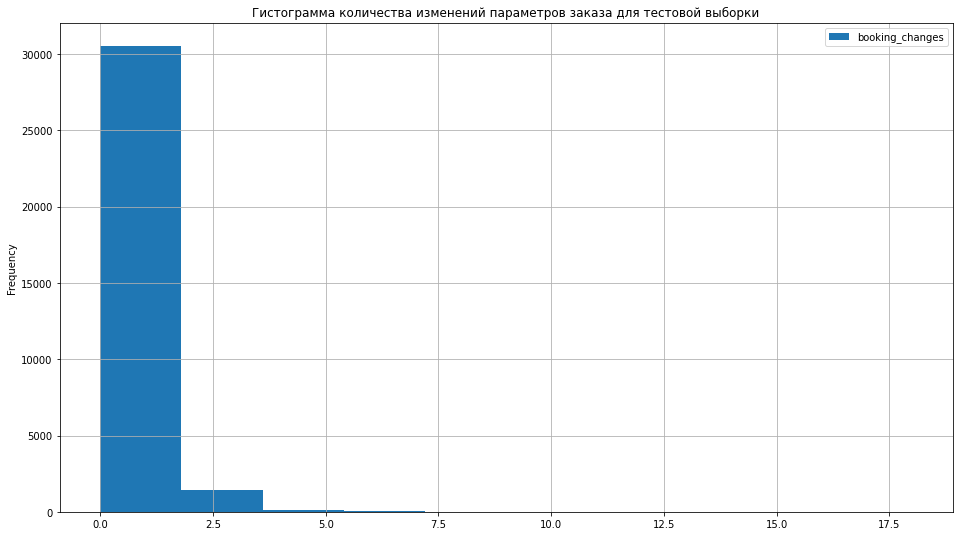

In [ ]:
hotel_train['booking_changes'].plot(kind='hist',figsize=(16,9), alpha = 0.5,grid=True, legend=True, title='Гистограмма количества изменений параметров заказа для обучающей выборки')
plt.show()
hotel_test['booking_changes'].plot(kind='hist',figsize=(16,9), grid=True, legend=True, title='Гистограмма количества изменений параметров заказа для тестовой выборки')
plt.show()

Из гистограммы сделаем вывод, что все значения больше 5 мы принимаем за выбросы, удаляем их.

In [ ]:
hotel_train = hotel_train.query('booking_changes < 6')
hotel_test = hotel_test.query('booking_changes < 6')

Рассмотрим значения столбца **days_in_waiting_list** (сколько дней заказ ожидал подтверждения), где медиана 0 и 3 квартиль тоже 0, а максимальные значения 259 и 223. Построим гистограмму

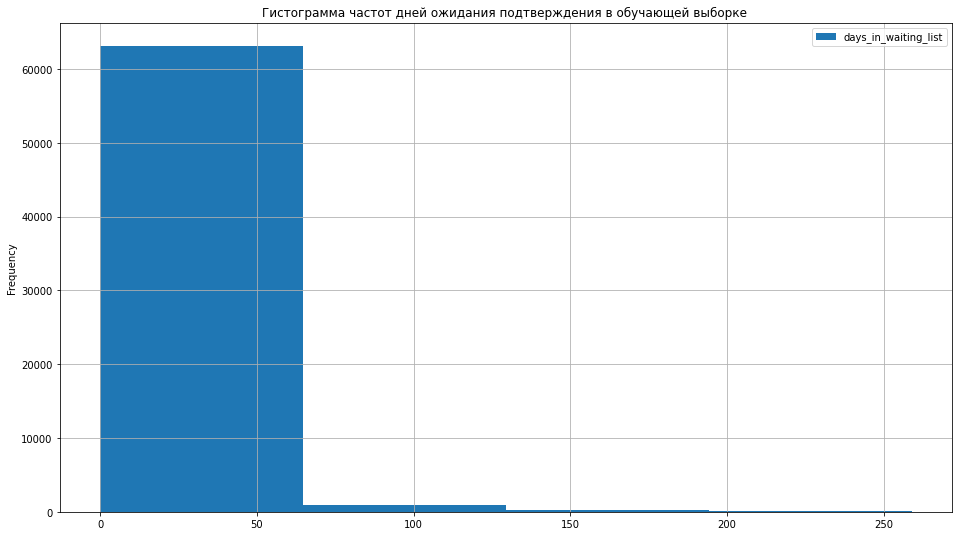

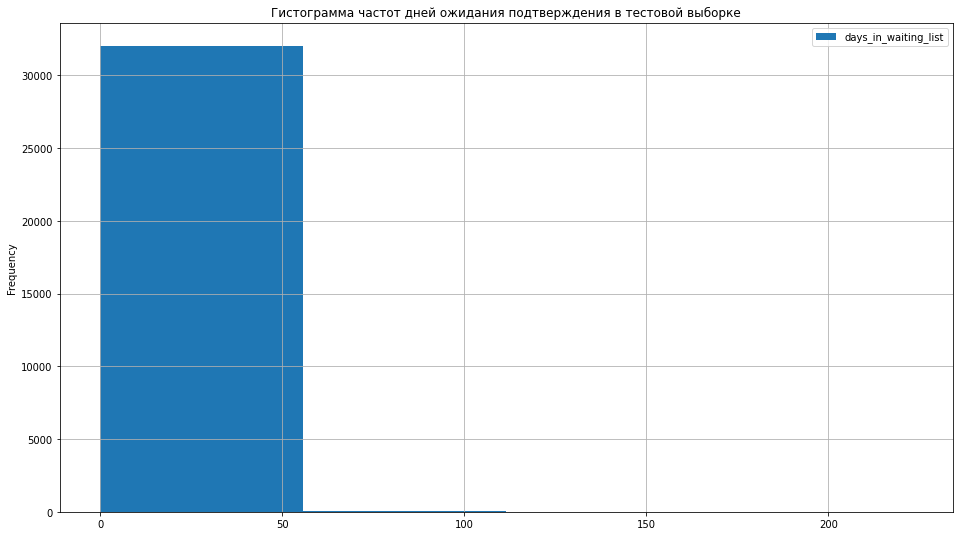

In [ ]:
hotel_train['days_in_waiting_list'].plot(kind='hist', bins=4, figsize=(16,9), grid=True, legend=True, title='Гистограмма частот дней ожидания подтверждения в обучающей выборке ')
plt.show()
hotel_test['days_in_waiting_list'].plot(kind='hist', bins=4, figsize=(16,9), grid=True, legend=True, title='Гистограмма частот дней ожидания подтверждения в тестовой выборке')
plt.show()

Из гистограммы сделаем вывод, что значения больше 50 дней, примем за выбросы. Удалим эти данные.

In [ ]:
hotel_train = hotel_train.query('days_in_waiting_list < 51')
hotel_test = hotel_test.query('days_in_waiting_list < 51')
print(hotel_train.shape[0])
print(hotel_test.shape[0])

62723
32036


Вывод:
 - Удалив выбросы, у нас осталось 62723 записи в обучающей выборке, 32036 записей в тестовой выборке.

Построим тепловую карту для изучения зависимостей признаков.

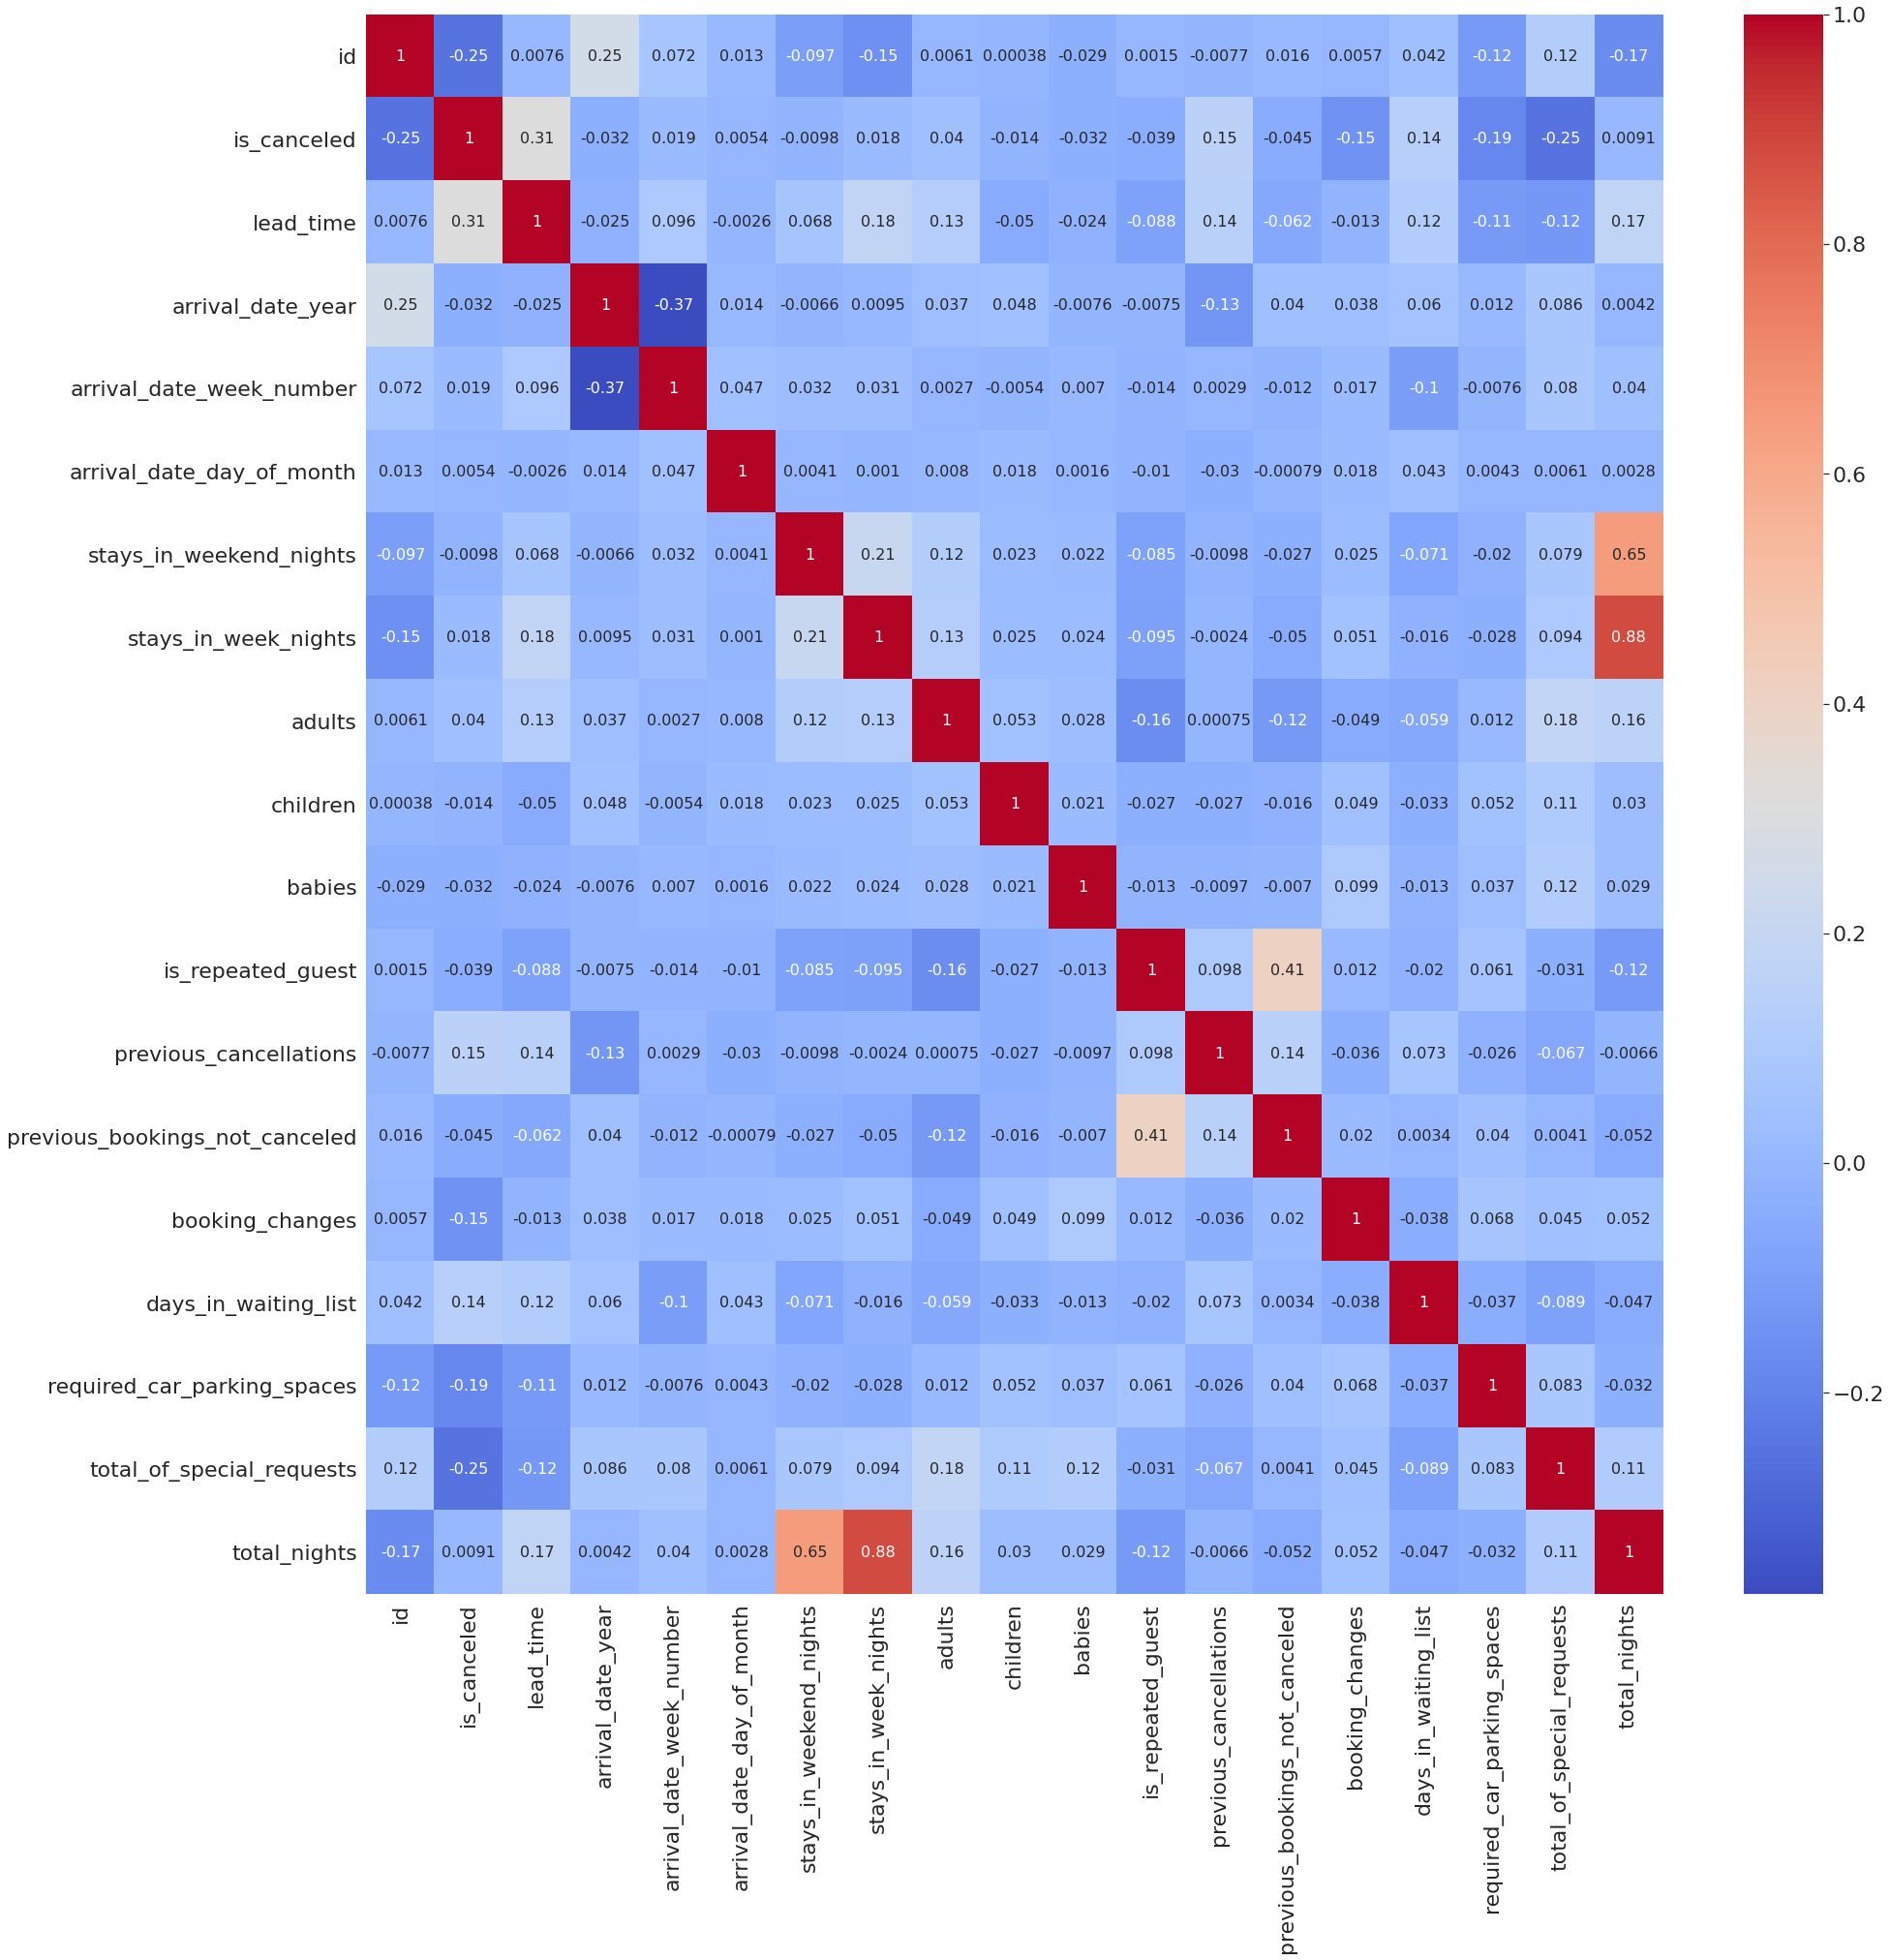

In [ ]:
plt.figure(figsize=(30, 30))
sns.set(font_scale=2)
sns.heatmap(hotel_train.corr(), annot = True, fmt='.2g', cmap= 'coolwarm', annot_kws={"fontsize":16})
plt.show()

Сильная корреляция между **stays_in_weekend_nights** и **total_nights** - `0.65`, между **stays_in_week_nights** и **total_nights** - `0.88`. В дальнейшем, при обучении модели необходимо будет избавиться от взаимосвязанных признаков.

#### Вывод:
 - При изучении датафреймов пропуски не обнаружены
 - Явных дубликатов не было обнаружено
     - Неявные дубликаты устранены в столбце **meal**
 - Убрали пропуски в **reserved_room_type**
 - Изменили тип данных с float64 на int64 в столбцах **lead_time, adults, children, babies**
 - Избавились от выбросов в столбцах **lead_time, adults, babies, required_car_parking_spaces, booking_changes , days_in_waiting_list**
 - Сильная корреляция признаков **total_nights** с **stays_in_weekend_nights** и **stays_in_week_nights**
 - `hotel_train` сократилось на 2506, `hotel_test` сократилось на 376 запись

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Из условий задания, нам известно, что:  

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.

Стоимость номеров отеля:  
категория A: за ночь — 1 000, разовое обслуживание — 400;  
категория B: за ночь — 800, разовое обслуживание — 350;  
категория C: за ночь — 600, разовое обслуживание — 350;  
категория D: за ночь — 550, разовое обслуживание — 150;  
категория E: за ночь — 500, разовое обслуживание — 150;  
категория F: за ночь — 450, разовое обслуживание — 150;  
категория G: за ночь — 350, разовое обслуживание — 150.  

Из данных к заданию, нам известно, что:  

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.  
  
Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

In [ ]:
def group_cost(row):
    if row['reserved_room_type'] == 'A':
        return 1000
    elif row['reserved_room_type'] == 'B':
        return 800
    elif row['reserved_room_type'] == 'C':
        return 600
    elif row['reserved_room_type'] == 'D':
        return 550
    elif row['reserved_room_type'] == 'E':
        return 500
    elif row['reserved_room_type'] == 'F':
        return 450
    elif row['reserved_room_type'] == 'G':
        return 350
hotel_test['cost_room'] = hotel_test.apply(group_cost, axis=1)

In [ ]:
def group_service(row):
    if row['reserved_room_type'] == 'A':
        return 400
    elif row['reserved_room_type'] in {'B', 'C'}:
        return 350
    else:
        return 150
hotel_test['one_time_room_service'] = hotel_test.apply(group_service, axis=1)

In [ ]:
def group_coefficient(row):
    if row['arrival_date_month'] in {'June', 'July', 'August'}:
        return 1.4
    elif row['arrival_date_month'] in {'December', 'January', 'February'}:
        return 1
    else:
        return 1.2
hotel_test['season_coefficient'] = hotel_test.apply(group_coefficient, axis=1)
hotel_test

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,cost_room,one_time_room_service,season_coefficient
0,6086,1,74,2017,January,1,1,1,0,2,...,A,0,0,Transient,0,0,1,1000,400,1.0
1,6087,1,62,2017,January,1,1,2,2,2,...,A,0,0,Transient,0,1,4,1000,400,1.0
2,6088,1,62,2017,January,1,1,2,2,2,...,A,0,0,Transient,0,1,4,1000,400,1.0
3,6089,1,71,2017,January,1,1,2,2,1,...,A,0,0,Transient,0,1,4,1000,400,1.0
4,6090,1,172,2017,January,1,1,2,5,2,...,A,0,0,Transient,0,0,7,1000,400,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32407,97899,0,164,2017,August,35,31,2,4,2,...,A,0,0,Transient,0,0,6,1000,400,1.4
32408,97900,0,21,2017,August,35,30,2,5,2,...,A,0,0,Transient,0,2,7,1000,400,1.4
32409,97901,0,23,2017,August,35,30,2,5,2,...,A,0,0,Transient,0,0,7,1000,400,1.4
32410,97902,0,34,2017,August,35,31,2,5,2,...,D,0,0,Transient,0,4,7,550,150,1.4


In [ ]:
def count_revenue(row):
    room_type = row['reserved_room_type']
    month = row['arrival_date_month']
    week_nights = row['stays_in_week_nights']
    weekend_nights = row['stays_in_weekend_nights']
    price = row['cost_room']
    season_coefficient = row['season_coefficient']

    prepare_cost = row['one_time_room_service']

    total_nights = week_nights + weekend_nights
    if (row['is_canceled'] == 0):

        prepare_nights = 1 + math.floor(total_nights / 2)

        revenue = season_coefficient*price*total_nights - prepare_nights*prepare_cost

    else:
        revenue = - (prepare_cost+price*season_coefficient)
    return revenue

Подсчитаем прибыль отеля без внедрения депозитов на тестовой выборке `hotel_test`

In [ ]:
total_revenue = hotel_test.apply(count_revenue, axis=1).sum()
total_revenue

32382450.0

Прибыль 32 млн 382 тысячи 450 рублей

### Шаг 4. Разработка модели ML

Для обучения модели необходимо выделить признаки и целевой признак. У нас задача классификации - будет отменена бронь или нет. Целевой признак - **is_canceled**.  

В качестве признаков будут столбцы **adults, arrival_date_week_number, babies, country, children, customer_type, days_in_waiting_list, is_repeated_guest, lead_time, meal, previous_bookings_not_canceled, previous_cancellations, required_car_parking_spaces, reserved_room_type, stays_in_weekend_nights, stays_in_week_nights, total_of_special_requests, is_canceled**.

Какие признаки не включаем:
 - **id** (номер записи) - не несет никакой важной информации, так как это просто способ упорядочить записи
 - **arrival_date_year** (год заезда) - не понадобится, так как в выборке прошедшие года, а модель предсказывает отмену в текущем
 - **arrival_date_month** — месяц заезда. Не включили, так как у нас есть номер недели, что уже включает информацию о месяце
 - **arrival_date_day_of_month** — день заезда. Сам по себе не информативен.
 - **distribution_channel** — канал дистрибуции заказа - этот признак важен, например, при прогнозировании рекламного бюджета, а когда клиент уже сделал бронирование, отмена не зависит от того, откуда клиент "пришел"
 - **total_nights** — общее количество ночей. Взаимозависим со столбцами 'stays_in_weekend_nights','stays_in_week_nights', поэтому не включаем.

Так же, создадим переменные `hotel_train_ohe` и `hotel_test_ohe`, чтобы в дальнейшем преобразовать категориальные признаки в количественные при помощи OneHotEncoder.

In [ ]:
columns_features = ['adults', 'arrival_date_week_number', 'babies', 'children', 'customer_type', 'country',
                    'days_in_waiting_list', 'is_repeated_guest', 'lead_time', 'meal', 'previous_bookings_not_canceled',
                   'previous_cancellations', 'required_car_parking_spaces', 'reserved_room_type', 'stays_in_weekend_nights',
                   'stays_in_week_nights', 'total_of_special_requests', 'is_canceled' ]

hotel_train_ohe = hotel_train[columns_features]
hotel_test_ohe = hotel_test[columns_features]

target_train = hotel_train_ohe['is_canceled']
target_test = hotel_test_ohe['is_canceled']

features_train = hotel_train_ohe.drop('is_canceled', axis=1)
features_test = hotel_test_ohe.drop('is_canceled', axis=1)

In [ ]:
hotel_train_ohe

,adults,arrival_date_week_number,babies,children,customer_type,country,days_in_waiting_list,is_repeated_guest,lead_time,meal,previous_bookings_not_canceled,previous_cancellations,required_car_parking_spaces,reserved_room_type,stays_in_weekend_nights,stays_in_week_nights,total_of_special_requests,is_canceled
0,1,27,0,0,Transient,GBR,0,0,7,BB,0,0,0,A,0,1,0,0
1,2,27,0,0,Transient,GBR,0,0,14,BB,0,0,0,A,0,2,1,0
2,2,27,0,0,Transient,PRT,0,0,0,BB,0,0,0,C,0,2,0,0
3,2,27,0,0,Transient,PRT,0,0,9,FB,0,0,0,C,0,2,1,0
4,2,27,0,0,Transient,PRT,0,0,85,BB,0,0,0,A,0,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65224,2,53,0,0,Transient,CHN,0,0,23,BB,0,0,0,D,2,4,2,0
65225,2,53,0,0,Transient,FRA,0,0,53,HB,0,0,0,D,2,3,3,0
65226,2,53,0,0,Transient,FRA,0,0,7,BB,0,0,0,D,2,4,1,0
65227,2,53,0,0,Transient,FRA,0,0,17,SC,0,0,0,A,2,5,1,0


##### дубликаты после удаления id     <a id='intro'></a>

In [ ]:
print(hotel_train_ohe.duplicated().sum())
print(hotel_test_ohe.duplicated().sum())

20580
7968


В таблице практически все столбцы, кроме **customer_type** и **meal** - количественные. Нам нужно построить модель, которая будет решать задачу классификации (отменит клиент бронь или нет). Применим технику OneHotEncoder, чтобы преобразовать категориальные переменные в количественные.

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')

Преобразуем обучающие и тестовые выборки функцией transform():

In [ ]:
enc.fit(features_train)
features_train = enc.transform(features_train)
features_test = enc.transform(features_test)

Далее обучим модели и оценим их качество кросс-валидацией. Для решения задачи классификации подойдут 3 модели: логистическая регрессия, решающее дерево и случайный лес. Начнем с логистической регрессии:

In [ ]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
scores = cross_val_score(model,features_train, target_train, cv=5, scoring='f1')
final_score = scores.mean()
print('Средняя оценка качества модели:', final_score)

Средняя оценка качества модели: 0.5240227930446978


Теперь перейдем к модели решающего дерева. В цикле переберем гиперпараметры (размер глубины), и выведем на экран при какой глубине результат кросс-валидации дал наивысшую оценку качества модели:

In [ ]:
%%time

col = ['max_depth', 'final_score']
data = []

for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    scores = cross_val_score(model,features_train, target_train, cv=5 , scoring='f1')
    final_score = sum(scores)/len(scores)
    data.append([depth, final_score])

table = pd.DataFrame(data = data, columns=col)

display(table[table['final_score']==table['final_score'].max()])

,max_depth,final_score
4,5,0.650293


CPU times: user 8.57 s, sys: 0 ns, total: 8.57 s
Wall time: 8.57 s


При max_depth=5 оценка качества модели кросс-валидацией достигает максимума в 0.65, что уже выше, чем в модели логистической регрессии

Посмотрим как с задачей справляется модель случайного леса RandomForestClassifier. В цикле переберем значения гиперпараметра n_estimators, который отвечает за количество деревьев в лесу. Выведем на экран значение n_estimators при котором возможно получить максимальную оценку качества модели, полученную кросс-валидацией

In [ ]:
%%time

col = ['n_estimators', 'final_score']
data = []

for est in range(1, 11):
    model = RandomForestClassifier(random_state=12345, n_estimators=est, class_weight='balanced')
    scores = cross_val_score(model,features_train, target_train, cv=5, scoring='f1')
    final_score = sum(scores)/len(scores)
    data.append([est, final_score])

table = pd.DataFrame(data = data, columns=col)

display(table[table['final_score']==table['final_score'].max()])


,n_estimators,final_score
0,1,0.463261


CPU times: user 3min 11s, sys: 113 ms, total: 3min 11s
Wall time: 3min 11s


Наибольшая оценка достигается при n_estimators=1 и равна 0.46.  

Таким образом, лучшая модель - решающее дерево при max_depth=5. Проверим ее на тестовой выборке. В качестве метрики оценки качества будем использовать F1-меру и метрику AUC-ROC. F1-мера - это агрегирующая метрика, среднее гармоническое полноты и точности. Метрика AUC-ROC показывает, как сильно наша модель отличается от случайной, так как AUC-ROC случайной модели равна 0.5.

Значение F1-меры на тестовой выборке: 0.633886436291673
Значение метрики AUC-ROC: 0.7747977285779039


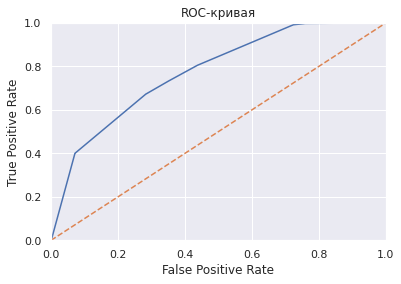

In [ ]:
model =  DecisionTreeClassifier(random_state=12345, max_depth=5, class_weight='balanced')
model.fit(features_train, target_train)


predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
test_f1_score = f1_score(target_test, predicted_test )
auc_roc = roc_auc_score(target_test, probabilities_one_test)

print('Значение F1-меры на тестовой выборке:', test_f1_score)
print('Значение метрики AUC-ROC:', auc_roc)

sns.set(font_scale=1)
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Модель решающего дерева при величине гиперпараметра max_depth=5 и величине порога = 0.3 показывает на тестовой выборке следующие результаты:
 - F1-мера - 0.634
 - Метрика AUC-ROC - 0.775

Проверим на адекватность выбранную нами модель. Для этого посмотрим, как справится с задачей фиктивный классификатор DummyClassifier. Он покажет вероятность успеха, даже если просто "угадать". Таким образом, чтобы признать модель адекватной, нужно, чтобы показатели метрик были выше, чем те, которые получатся у фиктивного классификатора. Так как от значения параметра strategy может поменяться результат, переберем их, и для сравнения будем учитывать лучший результат:

In [ ]:
%%time
names = ['stratified', 'most_frequent', 'prior', 'uniform']
data = []
col = ['name',  'f1_score_test', 'auc_roc_test']

for name in names:
    new_dummy_classifier = DummyClassifier(strategy=name)
    new_dummy_classifier.fit(features_train, target_train)
    test_predictions = new_dummy_classifier.predict(features_test)
    probabilities_test = new_dummy_classifier.predict_proba(features_test)
    probabilities_one_test = probabilities_test[:, 1]
    test_accuracy = accuracy_score(target_test, test_predictions)
    test_f1_score = f1_score(target_test, test_predictions )
    auc_roc_test = roc_auc_score(target_test, probabilities_one_test)
    data.append([name, test_f1_score, auc_roc_test])

table = pd.DataFrame(data = data, columns=col)
display(table[table['f1_score_test']==table['f1_score_test'].max()])

,name,f1_score_test,auc_roc_test
3,uniform,0.434614,0.5


CPU times: user 81.8 ms, sys: 11 µs, total: 81.8 ms
Wall time: 88 ms


Показатели у лучшего (при значении параметра strategy='uniform') из фиктивных классификаторов намного ниже, чем у нашей модели, и находятся на уровне 0.43 для F1-меры, а также 0.5- для метрики AUC-ROC. Модель прошла тест на адекватность.

Оценим прибыль, которую модель принесет за год

In [ ]:
model =  DecisionTreeClassifier(random_state=12345, max_depth=5, class_weight='balanced')
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)

Сохраним предсказания модели в таблице `hotel_test`, выведем значения на экран

In [ ]:
hotel_test['predictions'] = predicted_test
display(hotel_test.head())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,cost_room,one_time_room_service,season_coefficient,predictions
0,6086,1,74,2017,January,1,1,1,0,2,...,0,0,Transient,0,0,1,1000,400,1.0,1
1,6087,1,62,2017,January,1,1,2,2,2,...,0,0,Transient,0,1,4,1000,400,1.0,0
2,6088,1,62,2017,January,1,1,2,2,2,...,0,0,Transient,0,1,4,1000,400,1.0,0
3,6089,1,71,2017,January,1,1,2,2,1,...,0,0,Transient,0,1,4,1000,400,1.0,0
4,6090,1,172,2017,January,1,1,2,5,2,...,0,0,Transient,0,0,7,1000,400,1.0,1


Напишем функцию count_revenue, которая подсчитает прибыль отеля с учетом введения депозитов

In [ ]:
def count_revenue(row):
    room_type = row['reserved_room_type']
    month = row['arrival_date_month']
    week_nights = row['stays_in_week_nights']
    weekend_nights = row['stays_in_weekend_nights']
    price = row['cost_room']
    season_coefficient = row['season_coefficient']
    prepare_cost = row['one_time_room_service']
    total_nights = week_nights + weekend_nights

    if (row['is_canceled'] == 0):
        prepare_nights = 1 + math.floor(total_nights / 2)
        revenue = season_coefficient*price*total_nights - prepare_nights*prepare_cost

    else:
        revenue = - (prepare_cost+price*season_coefficient)

        if ('predictions' in list(row.index) and row['predictions'] == 1):
            revenue = revenue * 0.2

    return revenue

In [ ]:
total_revenue_deposit = hotel_test.apply(count_revenue, axis=1).sum()
total_revenue_deposit

42055634.0

42 млн 55 тысячи 634 рублей прибыль отеля с учетом введения депозитов

Посчитаем чистую прибыль отеля после введения системы депозитов с учетом стоимости разработки системы прогнозирования

Из условий задания мы знаем, что:
 - На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании

In [ ]:
IMPLEMENTATION_COST = 400000
net_profit = total_revenue_deposit  - total_revenue - IMPLEMENTATION_COST
net_profit

9273184.0

#### Вывод:
 - до внедрения депозитов отель получал прибыль 32 млн 382 тысячи 450 рублей
 - лучшая модель - решающее дерево (гиперпараметр max_depth=5)
 - метрики качества на тестовой выборке: F1-мера - 0.634, AUC-ROC - 0.775
 - прибыль после введения депозитов могла составить 42 млн 55 тысячи 634 рублей
 - с учетом стоимости введения системы депозитов, отель за год может получить дополнительно 9 млн 273 тысячи 184 рублей чистой прибыли

### Шаг 5. Опишите портрет «ненадёжного» клиента

Проанализируем бронирования, которые модель посчитала отмененными и те, которые действительно ими оказались. Вызовем метод describe, чтобы сразу увидеть медианное значение и квартили:

In [ ]:
hotel_test.query('is_canceled==1 and predictions==True').describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,cost_room,one_time_room_service,season_coefficient,predictions
count,8328.000000,8328.0,8328.000000,8328.0,8328.000000,8328.000000,8328.000000,8328.000000,8328.000000,8328.000000,...,8328.000000,8328.000000,8328.000000,8328.0,8328.0,8328.000000,8328.000000,8328.000000,8328.000000,8328.0
mean,43994.287224,1.0,118.785543,2017.0,17.613473,15.656460,0.837536,2.350024,1.878602,0.074087,...,0.006484,0.073967,0.202209,0.0,0.0,3.187560,899.837896,348.060759,1.228122,1.0
std,15104.615915,0.0,78.165201,0.0,8.405157,8.671792,0.854012,1.272082,0.467545,0.334065,...,0.302833,0.364847,2.513169,0.0,0.0,1.557552,193.853641,101.069804,0.138172,0.0
min,6086.000000,1.0,0.000000,2017.0,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,1.000000,350.000000,150.000000,1.000000,1.0
25%,46178.250000,1.0,56.000000,2017.0,11.000000,8.000000,0.000000,1.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,2.000000,1000.000000,400.000000,1.200000,1.0
50%,49065.000000,1.0,109.000000,2017.0,18.000000,15.000000,1.000000,2.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,3.000000,1000.000000,400.000000,1.200000,1.0
75%,51924.250000,1.0,169.000000,2017.0,24.000000,23.000000,2.000000,3.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,4.000000,1000.000000,400.000000,1.400000,1.0
max,91576.000000,1.0,349.000000,2017.0,35.000000,31.000000,4.000000,6.000000,4.000000,3.000000,...,26.000000,5.000000,50.000000,0.0,0.0,10.000000,1000.000000,400.000000,1.400000,1.0


На основе медианы и квартилей можно описать «ненадёжного» клиента
 - бронирует номер заранее, в основном - за 118 дней (lead_time — количество дней между датой бронирования и датой прибытия)
 - бронирует в основном номер на 3 ночи: 1 приходится на выходные(stays_in_weekend_nights), 2 - на будние(stays_in_week_nights)
 - это двое взрослых (adults) без детей(children) и младенцев(babies)
 - никогда не был клиентом отеля(is_repeated_guest), не отменял(previous_cancellations)
 - не указывает специальные отметки(total_of_special_requests), не вносит правки в бронь (booking_changes)
 - не запрашивает парковочное место(required_car_parking_spaces)

Проанализируем столбцы, содержащие категориальные переменные

In [ ]:
hotel_test.query('is_canceled==1 and predictions==True')['customer_type'].value_counts(normalize=True)

Transient          0.916427
Transient-Party    0.078770
Contract           0.004083
Group              0.000720
Name: customer_type, dtype: float64

В 91% случаев тип ненадежного клиента не связан с договором или групповым заездом (Transient)

In [ ]:
hotel_test.query('is_canceled==1 and predictions==True')['meal'].value_counts(normalize=True)

BB    0.826369
SC    0.120917
HB    0.051153
FB    0.001561
Name: meal, dtype: float64

В 82% случаев выбирают только завтраки(BB), в 94% - завтраки или ничего(BB+SC)

In [ ]:
hotel_test.query('is_canceled==1 and predictions==True')['reserved_room_type'].value_counts(normalize=True)

A    0.786383
D    0.148775
E    0.036143
F    0.012488
G    0.008886
C    0.005163
B    0.002161
Name: reserved_room_type, dtype: float64

В 3 из 4 бронирований «ненадёжные» клиенты предпочитают номера типа А

In [ ]:
hotel_test.query('is_canceled==1 and predictions==True')['distribution_channel'].value_counts(normalize=True)

TA/TO        0.903338
Direct       0.051153
Corporate    0.044188
GDS          0.001321
Name: distribution_channel, dtype: float64

В 90% случаев, канал дистрибуции был - TA/TO

#### Выводы:

Портрет «ненадёжного» клиента:
 - бронирует номер заранее, в основном - за 118 дней
 - бронирует в основном номер на 3 ночи: 1 приходится на выходные, 2 - на будние
 - это двое взрослых без детей и младенцев
 - никогда не был клиентом отеля, не отменял и не заказывал номера ранее
 - не указывает специальные отметки, не вносит правки в бронь
 - не запрашивает парковочное место
 - не связан с договором или групповым заездом
 - вместе с номером выбирает включенный в стоимость завтрак или ничего
 - выбирает самый дорогую по стоимости категорию номера (А)
 - канал дистрибуции - TA/TO

### Шаг 6. Напишите общий вывод

Заказчиком исследования была сеть отелей «Как в гостях».  

Задачей было разработать систему, которая предсказывает отказ от брони. Приням во внимание бизнес-метрики, разработали модели ML, выбрали лучшую. После настройки гиперпараметров, ей оказалась модель Решающее дерево.

Был описан портрет «ненадёжного» клиента: бронирует номер заранее, в основном - за 118 дней, бронирует в основном номер на 3 ночи: 1 приходится на выходные, 2 - на будние, это двое взрослых без детей и младенцев, никогда не был клиентом отеля, не отменял и не заказывал номера ранее, не указывает специальные отметки, не вносит правки в бронь, не запрашивает парковочное место, не связан с договором или групповым заездом, вместе с номером выбирает включенный в стоимость завтрак или ничего, выбирает самый дорогую по стоимости категорию номера (А), канал дистрибуции - TA/TO.

Мы высчитали, что, с учетом стоимости введения системы депозитов, отель за год может получить дополнительно 9 млн 273 тысячи чистой прибыли.

С учетом вышеперечисленного, можно дать рекомендацию бизнесу внедрять систему депозитов, использовать модель предсказания отказа от бронирования, использовать портрет «ненадёжного» клиента в работе.